In [1]:
from src.env_hiv import HIVPatient
import numpy as np
from gymnasium.wrappers import TimeLimit
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

import numpy as np
import os
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
import joblib   # Use this import instead if you have a newer version of scikit-learn

In [81]:
env = TimeLimit(HIVPatient(domain_randomization=False), max_episode_steps=200)
env.reset(mode = 'healthy')



(array([9.67839e+05, 7.60000e+01, 6.21000e+02, 6.00000e+00, 4.15000e+02,
        3.53108e+05]),
 {})

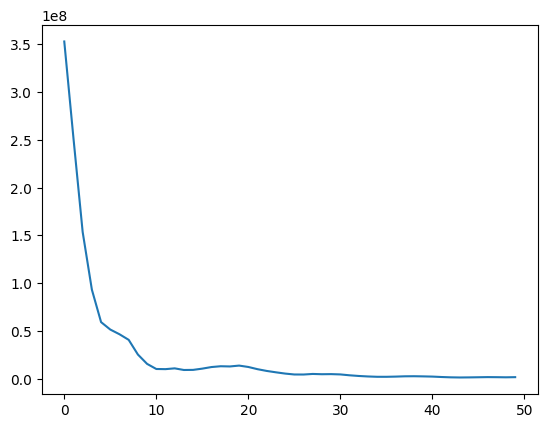

In [82]:
plt.plot([env.step(env.action_space.sample())[1] for i in range(50)])

100%|██████████| 4/4 [00:26<00:00,  6.67s/it]


(6400, 7)


100%|██████████| 4/4 [00:55<00:00, 13.84s/it]/s] 


Episode 11, Total Number of collected samples: 12800
(12800, 7)


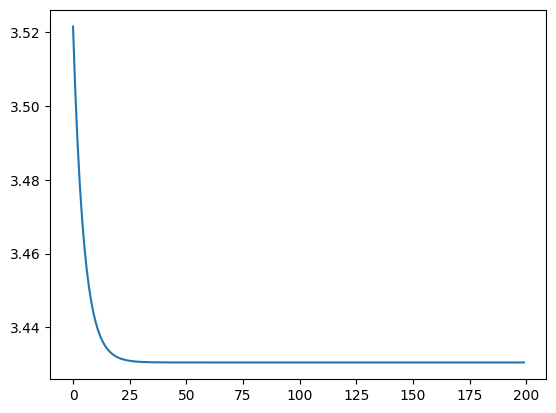

100%|██████████| 4/4 [00:55<00:00, 13.78s/it]it]  


Episode 21, Total Number of collected samples: 19200
(19200, 7)


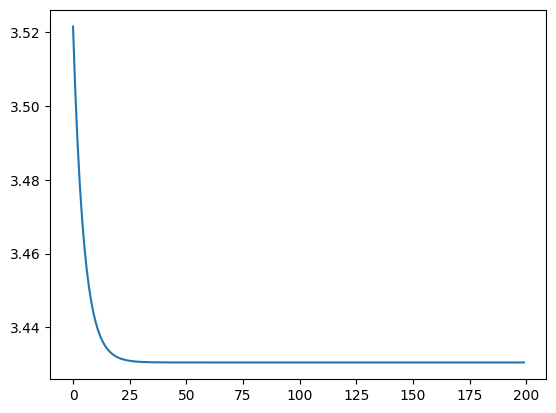

100%|██████████| 4/4 [00:56<00:00, 14.09s/it]it]


Episode 31, Total Number of collected samples: 25600
(25600, 7)


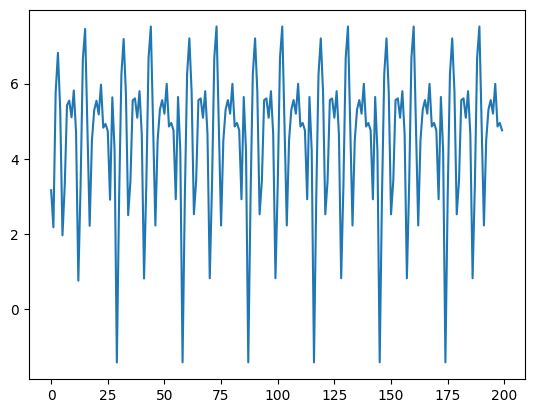

100%|██████████| 4/4 [00:54<00:00, 13.60s/it]it]


Episode 41, Total Number of collected samples: 32000
(32000, 7)


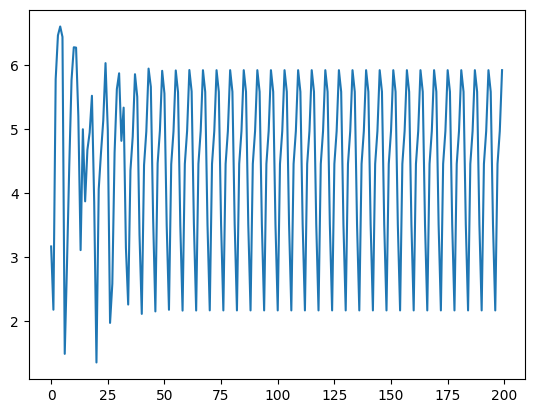

100%|██████████| 4/4 [00:57<00:00, 14.37s/it]it]


Episode 51, Total Number of collected samples: 38400
(38400, 7)


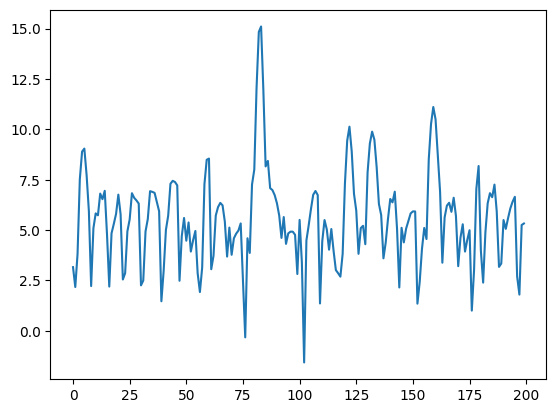

100%|██████████| 4/4 [00:59<00:00, 14.99s/it]it]


Episode 61, Total Number of collected samples: 44800
(44800, 7)


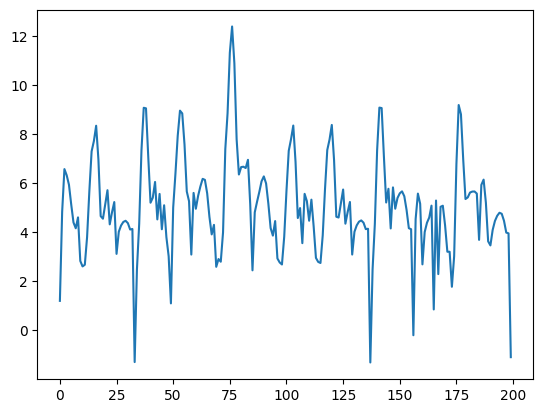

100%|██████████| 4/4 [00:55<00:00, 13.92s/it]it]


Episode 71, Total Number of collected samples: 51200
(51200, 7)


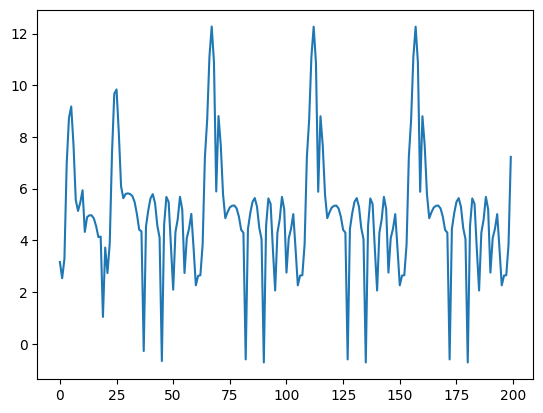

100%|██████████| 4/4 [00:55<00:00, 13.96s/it]it]


Episode 81, Total Number of collected samples: 57600
(57600, 7)


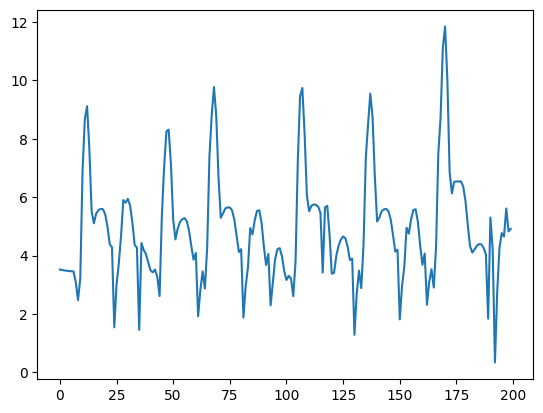

100%|██████████| 4/4 [00:59<00:00, 14.97s/it]it]


Episode 91, Total Number of collected samples: 64000
(64000, 7)


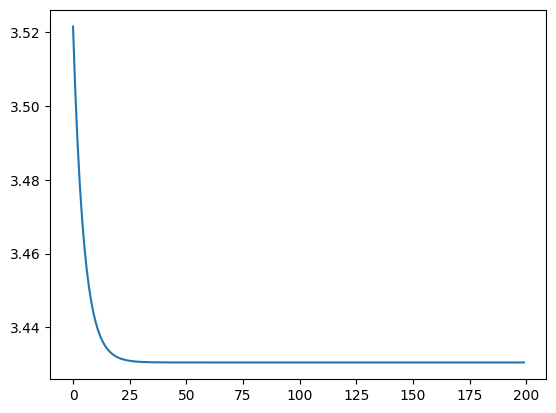

100%|██████████| 4/4 [00:55<00:00, 13.90s/it]/it]


Episode 101, Total Number of collected samples: 70400
(70400, 7)


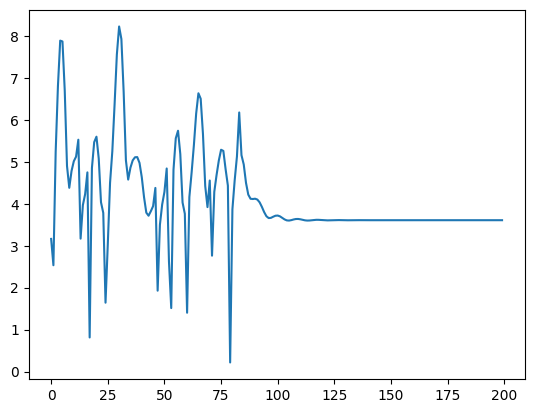

 54%|█████▍    | 108/200 [16:06<11:55,  7.78s/it]

In [231]:
from gymnasium.vector.async_vector_env import AsyncVectorEnv
import gymnasium as gym

class ProjectAgent:
    def __init__(self):
        self.Qfunction = None
        self.n_actions = 4

    def act(self, observation, use_random=False):
        if use_random:
            return np.random.randint(0, 4)
        else :
            Qsa = []
            for a in range(self.n_actions):
                sa = np.append(observation,a).reshape(1, -1)
                Qsa.append(self.Qfunction.predict(sa)) 
            return np.argmax(Qsa) 

    def save(self, path):
        if self.Qfunction is not None:
            joblib.dump(self.Qfunction, path)
        else:
            print("No Q-function to save.")

    def load(self, path):
        if os.path.exists(path):
            self.Qfunction = joblib.load(path)
            print("Loaded Q-function model.")
        else:
            print("File does not exist.")

    def create_env_fn(self, mode, env_class, max_episode_steps=200):
        # This method now returns a callable that initializes the environment
        def _init():
            env = TimeLimit(env_class(domain_randomization=True), max_episode_steps=max_episode_steps)
            env.reset(mode=mode)
            return env
        return _init
    
    def collect_samples(self, horizon, n_envs, n_reset, use_Q=False):
        env_fns = [self.create_env_fn('unhealthy', env_class = HIVPatient) for _ in range(n_envs)]
        vector_env = AsyncVectorEnv(env_fns)
        S, A, R, S2, D = [], [], [], [], []
        epsilon = 0.1
        for i in tqdm(range(n_reset // n_envs)):
            states = vector_env.reset()[0]  # Ensure 'states' is a list
            for _ in range(horizon):
                actions = np.zeros((n_envs,), dtype=np.int32)
                for env_idx in range(n_envs):
                    state = states[env_idx]
                    if not use_Q:
                        actions[env_idx] = vector_env.single_action_space.sample()
                    else:
                        if np.random.random() > epsilon :
                            actions[env_idx] = self.act(state)
                        else :
                            actions[env_idx] = vector_env.single_action_space.sample()
                        
                next_states, rewards, dones, truncs, _ = vector_env.step(actions)
                # Process and store the results
                for env_idx, (state, action, reward, next_state, done) in enumerate(zip(states, actions, rewards, next_states, dones)):
                    S.append(state)
                    A.append(action)
                    R.append(reward)
                    S2.append(next_state)
                    D.append(done)
                    if not done and not truncs[env_idx]:
                        states[env_idx] = next_state  # List item assignment should work
        A = np.array(A)
        return map(np.array, [S, A.reshape((-1,1)), R, S2, D])

    def train(self, env, horizon=200, n_reset=32, nb_episodes=200, n_envs=8):
        # Initializing the arrays for storing samples
        obs_space_dim = 4
        obs_space_dim = env.observation_space.shape[0]
        S, A, R, S2, D = (np.empty((0, obs_space_dim)), np.empty((0, 1)), np.empty(0), 
                        np.empty((0, obs_space_dim)), np.empty(0))

        Qfunctions = []
        SA = np.hstack((S, A))

        for episode in tqdm(range(nb_episodes)):
            if episode == 0:
                new_S, new_A, new_R, new_S2, new_D = self.collect_samples(horizon, n_envs, n_reset)
                S = new_S
                A = new_A.reshape(-1, 1)  # Ensure correct shape
                R = new_R
                S2 = new_S2
                D = new_D
                value = R.copy()
                SA = np.hstack((S, A))
                print(SA.shape)

            if episode > 0 and (episode % (nb_episodes // 20) == 0):
                eps = 0.1  # Unused epsilon, assuming it was intended for an epsilon-greedy policy
                new_S, new_A, new_R, new_S2, new_D = self.collect_samples(horizon, n_envs, n_reset, use_Q=True)
                S = np.vstack((S, new_S))
                A = np.vstack((A, new_A.reshape(-1, 1)))  # Ensure correct shape
                R = np.concatenate((R, new_R))
                S2 = np.vstack((S2, new_S2))
                D = np.concatenate((D, new_D))

                # Training feedback
                print(f"Episode {episode + 1}, Total Number of collected samples: {S.shape[0]}")
                SA = np.hstack((S, A))  # Combine state and action for training
                print(SA.shape)

                # Initializing a new environment instance for evaluation
                env=TimeLimit(HIVPatient(), max_episode_steps=200)
                rewards = []
                obs, info = env.reset()
                done = False
                truncated = False
                episode_reward = 0
                while not done and not truncated:
                    action = agent.act(obs)
                    obs, reward, done, truncated, _ = env.step(action)
                    episode_reward += reward
                    rewards.append(reward * 1e-6 * 200)

                plt.plot(rewards)
                plt.show()

            # Q-learning update
            if episode > 0:
                Q2 = np.zeros((len(S), 4))
                for a2 in range(4):  # Assuming 4 is the total number of actions
                    A2 = a2 * np.ones((len(S), 1))
                    S2A2 = np.hstack((S2, A2))
                    Q2[:, a2] = self.Qfunction.predict(S2A2)
                max_Q2 = np.max(Q2, axis=1)
                value = R + 0.99 * (1 - D) * max_Q2

            Q = RandomForestRegressor()
            Q.fit(SA, value)  
            Qfunctions.append(Q)
            self.Qfunction = Q

        self.Qfunction = Qfunctions[-1]

# Assuming TimeLimit and HIVPatient are properly imported and defined
env = TimeLimit(HIVPatient(domain_randomization=True), max_episode_steps=200)
agent = ProjectAgent()
agent.train(env)
agent.save("agent_state.pkl")  

In [223]:
agent = ProjectAgent()
agent.load('/Users/michaeleindor/Documents/MVA/RL/RLclass_MVA-main/rl-class-assignment-michaelndor/agent_state.pkl')
env=TimeLimit(HIVPatient(), max_episode_steps=200)

Loaded Q-function model.


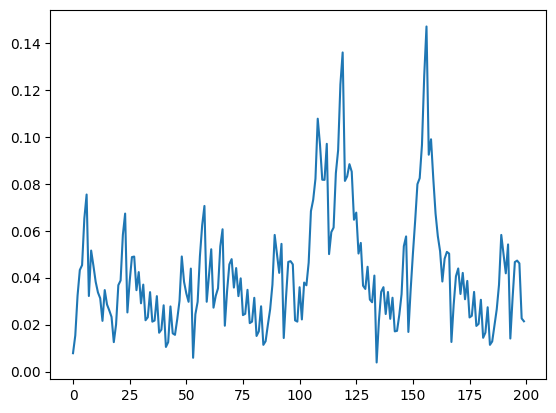

In [224]:
env=TimeLimit(HIVPatient(), max_episode_steps=200)
rewards = []
obs, info = env.reset()
done = False
truncated = False
episode_reward = 0
while not done and not truncated:
    action = agent.act(obs)
    obs, reward, done, truncated, _ = env.step(action)
    episode_reward += reward
    rewards.append(reward * 1e-6)
plt.plot(rewards)

In [225]:
from functools import partial
from statistics import mean
from functools import partial
import gymnasium as gym
from gymnasium.wrappers import TimeLimit


def evaluate_agent(agent, env, nb_episode) -> float:
    rewards: list[float] = []
    with tqdm(total=nb_episode, desc="") as pbar:
        for _ in tqdm(range(nb_episode), ):
            obs, info = env.reset()
            done = False
            truncated = False
            episode_reward = 0
            while not done and not truncated:
                action = agent.act(obs)
                obs, reward, done, truncated, _ = env.step(action)
                episode_reward += reward
            rewards.append(episode_reward)
            print(episode_reward*1e-6, 'e6')
    return mean(rewards)


evaluate_HIV = partial(
    evaluate_agent, agent = agent, env=TimeLimit(HIVPatient(), max_episode_steps=200)
)

evaluate_HIV_population = partial(
    evaluate_agent, agent = agent, env=TimeLimit(HIVPatient(domain_randomization=True), max_episode_steps=200),
)


In [226]:
evaluate_HIV_population(nb_episode = 100)

  0%|          | 0/100 [00:00<?, ?it/s]

10.16413624880936 e6


37.94152929798754 e6


  0%|          | 0/100 [00:20<?, ?it/s]


KeyboardInterrupt: 